# Circulation
This plots the stream function when monsoon is occuring in summer, and just prior to this at the equinox.

In [88]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
matplotlib.rcParams['lines.linewidth'] = 0.8          # make lines bigger for presentation

In [237]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth, c_p
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.utils.circulation import get_stream
from isca_tools.utils.calculus import grad_y

In [188]:
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
var_keep = ['ucomp', 'vcomp', 'omega', 'height', 'temp', 'sphum']      # only keep winds
tau_lw = 1
tau_lw_warm = 2
exp_names = [f"k={str(tau_lw).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []

# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
lat_use = slice(-65, 65)        # only interested where Hadley circulation occurs
summer_months = [6, 7, 8]
just_summer = True

for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep].sel(lat=lat_use)
    # Take zonal mean
    ds_use = annual_mean(ds_use.sel(time=slice(use_time_start, np.inf)).mean(dim=['lon']))
    if just_summer:
        ds += [annual_time_slice(ds_use, include_months=summer_months).load()]
    else:
        ds += [ds_use.load()]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

100%|██████████| 2/2 [00:19<00:00,  9.81s/it]


In [189]:
# If true, will save all figures to desktop - option to save specific figures later on.
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [190]:
ind_eq = int(np.abs(ds[0].lat).argmin())
ind_surf = int(np.abs(ds[0].pfull).argmax())
p_ft_approx = 500
ind_ft = int(np.abs(ds[0].pfull - p_ft_approx).argmin())
n_pressure = ds[0].pfull.size
n_lat = ds[0].lat.size

## Subtropical Temperature Amplification
For our aquaplanet simulations, we see temperature is peaked off the equator. The amplitude of this peak increases with warming, both at the surface (solid) and free troposphere (dotted).

It seems we should explain this before introducing land.

Text(0, 0.5, 'Temperature relative to equator [K]')

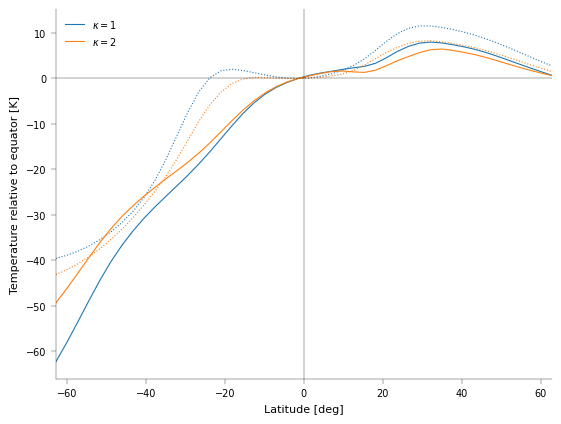

In [191]:
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar))
for i in range(n_exp):
    ds_use = ds[i].isel(pfull=[ind_surf, ind_ft]).temp.mean(dim='time')
    ds_use = (ds_use - ds_use.isel(lat=ind_eq))
    ax.plot(ds_use.lat, ds_use[0], color=default_colors[i], label=f'$\kappa = {tau_lw[i]}$')
    ax.plot(ds_use.lat, ds_use[1], color=default_colors[i], linestyle=':')
ax.legend()
ax.set_xlim(-ds[0].lat.max(), ds[0].lat.max())
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Temperature relative to equator [K]')

## Circulation changes
We see that with warming, $v$ becomes less northward at the surface, and $\omega$ becomes less upward at the north edge of the Hadley cell.

With warming, it appears that $v$ remains northward up to a higher altitude. This may offset the reduction in $v$ at the surface when 
it comes to mass conservation.

There certainly seems to be a split around 500hPa, below this (closer to the surface) the circulation gets weaker with warming. Above it, the circulation gets stronger with warming.

This is also reflected in $\omega$. With warming, we see less (more) ascent below (above) 500hPa at the northward edge of the cell.

We see that the most negative $u$ stays pretty constant with warming, but moves to a higher altitude. By thermal wind, you would expect the most negative $u$ to become less negative with warming because the temperature gradient, $dT/dy$ becomes less positive at this latitude.

In [192]:
stream = np.zeros((n_exp, n_pressure, n_lat))
for i in range(n_exp):
    for j in range(n_pressure):
        # integrate from surface each time, hence weird indexing
        ds_use = ds[i].vcomp.isel(pfull=np.arange(ind_surf, ind_surf-j-1, -1)).mean(dim='time')
        stream[i, ind_surf-j] = get_stream(ds_use, ds_use.pfull*100, ds_use.lat)

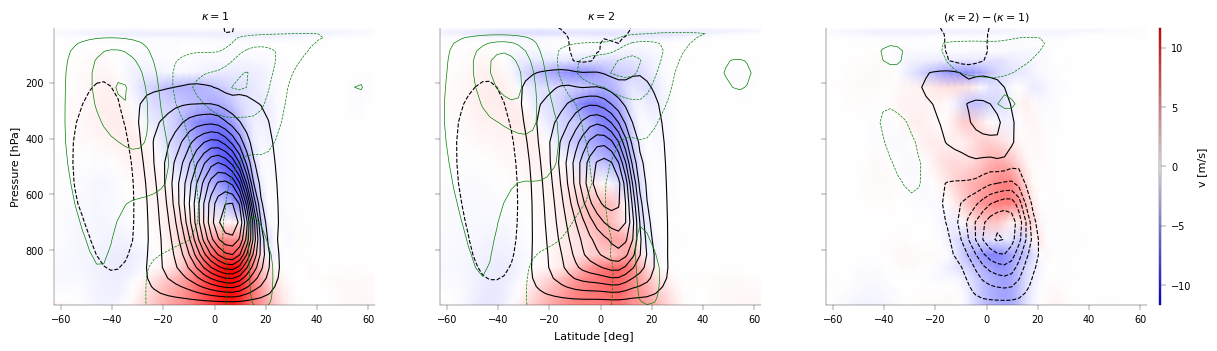

In [254]:
var = {'v': np.asarray([ds[i].mean(dim='time').vcomp.to_numpy() for i in range(n_exp)]), 
       'u': np.asarray([ds[i].mean(dim='time').ucomp.to_numpy() for i in range(n_exp)]), 
       'omega': np.asarray([ds[i].mean(dim='time').omega.to_numpy() for i in range(n_exp)]), 
       'dTdy': np.asarray([grad_y(ds[i].temp.mean(dim='time'), ds[0].lat, lat_axis=-1) for i in range(n_exp)])}
var_units = {'v': 'm/s', 'u': 'm/s', 'omega': 'Pa/s', 'dTdy': 'K/m'}
step_level = {'stream': 50e9*1.5, 'u': 20}
levels = {'stream': np.arange(-np.abs(stream).max(), np.abs(stream).max() + step_level['stream'], step_level['stream']), 
          'u': np.arange(-np.abs(var['u']).max(), np.abs(var['u']).max() + step_level['u'], step_level['u'])}
var_color = 'v'
fig, ax = plt.subplots(1,3, figsize=(3*1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True, sharex=True)
for i in range(n_exp):
    ax[i].contour(ds[i].lat, ds[i].pfull, stream[i], colors='k', levels=levels['stream'])
    ax[i].contour(ds[i].lat, ds[i].pfull, var['u'][i], colors='green', levels=levels['u'], linewidths=0.5)
    ax[i].pcolormesh(ds[i].lat, ds[i].pfull, var[var_color][i], 
                          cmap='bwr', shading='gouraud', vmax=np.max(np.abs(var[var_color])), vmin=-np.max(np.abs(var[var_color])))
    ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
ax[2].contour(ds[0].lat, ds[0].pfull, stream[1]-stream[0], colors='k', levels=levels['stream'])
ax[2].contour(ds[0].lat, ds[0].pfull, var['u'][1]-var['u'][0], colors='green', levels=levels['u'], linewidths=0.5)
im = ax[2].pcolormesh(ds[0].lat, ds[0].pfull, var[var_color][1]-var[var_color][0], 
                      cmap='bwr', shading='gouraud', vmax=np.max(np.abs(var[var_color])), vmin=-np.max(np.abs(var[var_color])))
fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.01, fraction=0.01, label=f"{var_color} [{var_units[var_color]}]")
ax[2].set_title(f'$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$')
ax[0].invert_yaxis()
fig.supxlabel('Latitude [deg]', fontsize=8)
ax[0].set_ylabel('Pressure [hPa]');